In [58]:
import torch
import torch.nn as nn
from torch import tensor
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import torch.optim as optim
import torchvision

In [59]:

class TinyImageNet(ImageFolder):
    """A generic data loader where the images are arranged in this way: ::

        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/xxz.png

        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/asd932_.png

    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
        is_valid_file (callable, optional): A function that takes path of an Image file
            and check if the file is a valid file (used to check of corrupt files)

     Attributes:
        classes (list): List of the class names sorted alphabetically.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """

    def __init__(
            self,
            root,
            transform=None,
            target_transform=None,
            is_valid_file=None,
    ):
        super(TinyImageNet, self).__init__(root,
                                          transform=transform,
                                          target_transform=target_transform,
                                          is_valid_file=is_valid_file)
        self.imgs = self.samples

transform = transforms.Compose([
    transforms.RandomRotation(20), # Image augmentation
    transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
if __name__ == "__main__":
    trainset = TinyImageNet(root='/Users/albertovalencia/Cogs181FinalProject/tiny-imagenet-200/train',transform=transform)
    testset = TinyImageNet(root='/Users/albertovalencia/Cogs181FinalProject/tiny-imagenet-200/test',transform=transform)

In [60]:
trainloader= torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=0)
testloader= torch.utils.data.DataLoader(testset, batch_size=4,shuffle=True, num_workers=0)

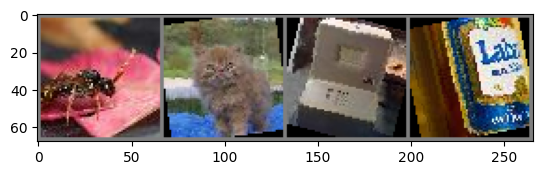

In [61]:
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [63]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layer_one = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3 , stride=1, padding=1)
        self.conv_layer_two = nn.Conv2d(in_channels=32,out_channels=20,kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(5120,1280)
        self.fc2 = nn.Linear(1280,640)
        self.fc3 = nn.Linear(640,200)
        
    def forward(self, x):
        x = self.conv_layer_one(x)
        x = F.relu(x)
        x = F.avg_pool2d(x,(2,2))
        x = self.conv_layer_two(x)
        x = F.relu(x)
        x = F.avg_pool2d(x,(2,2))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
    

net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (conv_layer_one): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_layer_two): Conv2d(32, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=5120, out_features=1280, bias=True)
  (fc2): Linear(in_features=1280, out_features=640, bias=True)
  (fc3): Linear(in_features=640, out_features=200, bias=True)
)

In [64]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

In [65]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 10000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

KeyboardInterrupt: 

In [ ]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

## Evaluate on Test Set

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))